# Brain Tumor Detection

### Importing Libraries

In [27]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import cv2
import os
from PIL import Image
import imageio
import tensorflow as tf 
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import normalize 
from tensorflow.keras import Sequential
from tensorflow.keras.layers import (Conv2D, MaxPooling2D,
     Activation, Dropout, Flatten, Dense)
from tensorflow.keras.utils import to_categorical

### Data Lodaing & Framing

In [28]:
image_directory = 'datasets/'
no_tumor_images = os.listdir(image_directory + 'no/')
yes_tumor_images = os.listdir(image_directory + 'yes/')

In [2]:
img = cv2.imread(image_directory+ "yes/"+ "y652.jpg")
img.shape

(324, 278, 3)

C:\Users\Safi\AppData\Local\Temp\ipykernel_8876\3968788476.py:3: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(image_directory+ "yes/"+ "y652.jpg")


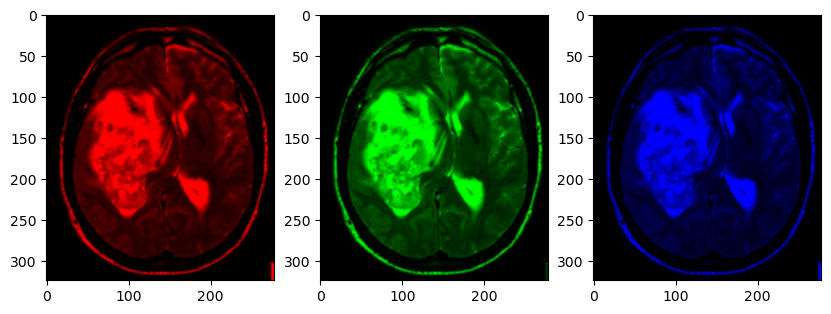

In [3]:
image = imageio.imread(image_directory+ "yes/"+ "y652.jpg")

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 5))

red_image = image.copy()
red_image[:, :, 1] = 0
red_image[:, :, 2] = 0

green_image = image.copy()
green_image[:, :, 0] = 0
green_image[:, :, 2] = 0

blue_image = image.copy()
blue_image[:, :, 0] = 0
blue_image[:, :, 1] = 0

axes[0].imshow(red_image)
axes[1].imshow(green_image)
axes[2].imshow(blue_image)


## 1. Exploratory Data Analysis

In [4]:
no_img_label = []
no_img_width = []
no_img_height = []

for i, image_name in enumerate(no_tumor_images):
    if image_name.split(".")[1] == 'jpg':
        no_img_label.append(image_name.split(".")[0])

        img = cv2.imread(image_directory+ "no/"+ image_name)
        no_img_width.append(img.shape[0])
        no_img_height.append(img.shape[1])

In [5]:
no_info = {"image_label":no_img_label, "image_width":no_img_width, "image_height":no_img_height}
no_images_info_df = pd.DataFrame(no_info)
no_images_info_df

,image_label,image_width,image_height
0,no0,630,630
1,no1,198,150
2,no10,225,225
3,no100,217,232
4,no1000,194,259
...,...,...,...
1495,no995,221,228
1496,no996,225,225
1497,no997,225,225
1498,no998,225,225


In [6]:
no_images_info_df.describe()

,image_width,image_height
count,1500.000000,1500.000000
mean,306.702667,299.980667
std,141.918226,148.211275
min,168.000000,150.000000
25%,225.000000,214.000000
50%,238.000000,227.000000
75%,400.000000,368.000000
max,1080.000000,1920.000000


array([[<Axes: title={'center': 'image_width'}>,
        <Axes: title={'center': 'image_height'}>]], dtype=object)

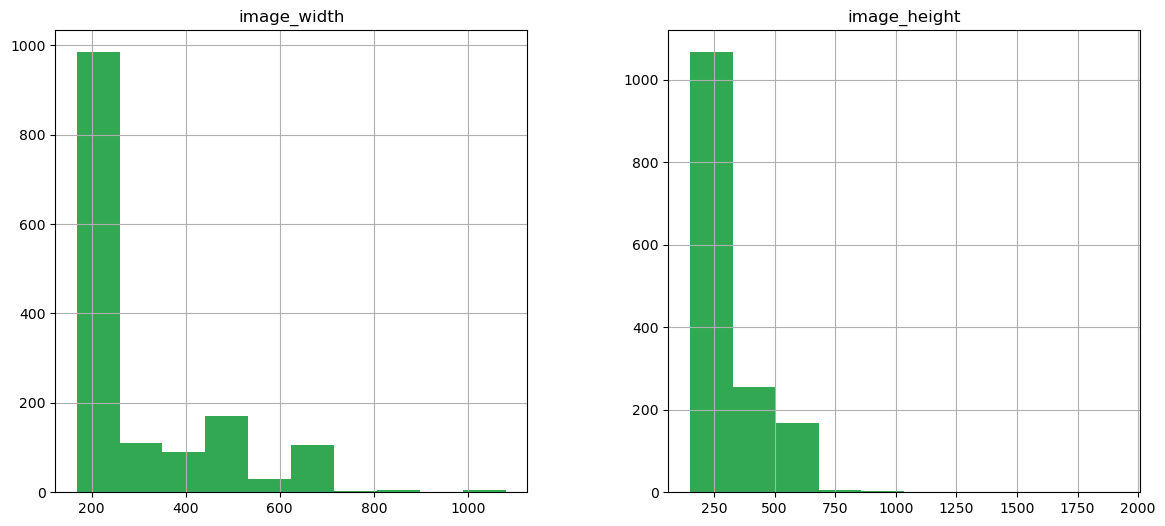

In [7]:
no_images_info_df[["image_width", "image_height"]].hist(figsize=(14,6), bins=10, color='#32a852') 

In [8]:
yes_img_label = []
yes_img_width = []
yes_img_height = []

for i, image_name in enumerate(yes_tumor_images):
    if image_name.split(".")[1] == 'jpg':
        yes_img_label.append(image_name.split(".")[0])

        img = cv2.imread(image_directory+ "yes/"+ image_name)
        yes_img_width.append(img.shape[0])
        yes_img_height.append(img.shape[1])
        
yes_info = {"image_label":yes_img_label, "image_width":yes_img_width, "image_height":yes_img_height}
yes_images_info_df = pd.DataFrame(yes_info)
yes_images_info_df

,image_label,image_width,image_height
0,y0,348,287
1,y1,630,587
2,y10,879,766
3,y100,630,630
4,y1000,336,264
...,...,...,...
1495,y995,334,283
1496,y996,354,303
1497,y997,348,297
1498,y998,1200,1059


array([[<Axes: title={'center': 'image_width'}>,
        <Axes: title={'center': 'image_height'}>]], dtype=object)

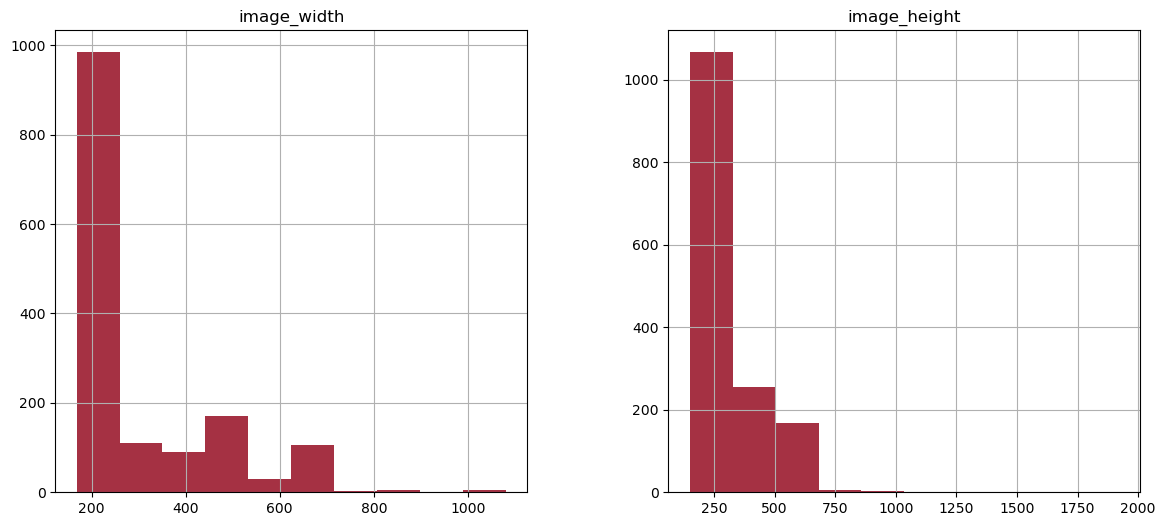

In [9]:
no_images_info_df[["image_width", "image_height"]].hist(figsize=(14,6), bins=10, color='#A53143')

In [10]:
yes_images_info_df.describe()

,image_width,image_height
count,1500.000000,1500.000000
mean,398.853333,350.455333
std,206.095229,193.916053
min,167.000000,175.000000
25%,294.000000,247.500000
50%,342.000000,283.000000
75%,380.000000,353.000000
max,1427.000000,1275.000000


In [12]:
image_directory = 'datasets/'
no_tumor_images = os.listdir(image_directory + 'no/')
yes_tumor_images = os.listdir(image_directory + 'yes/')

dataset=[]
label=[]

INPUT_SIZE=64

for i, image_name in enumerate(no_tumor_images):
    if image_name.split(".")[1] == 'jpg':
        image = cv2.imread(image_directory+"no/"+image_name)
        image = Image.fromarray(image, "RGB")
        image = image.resize((INPUT_SIZE, INPUT_SIZE))
        dataset.append(np.array(image))
        label.append(0)

for i, image_name in enumerate(yes_tumor_images):
    if image_name.split(".")[1] == 'jpg':
        image = cv2.imread(image_directory+"yes/"+image_name)
        image = Image.fromarray(image, "RGB")
        image = image.resize((INPUT_SIZE, INPUT_SIZE))
        dataset.append(np.array(image))
        label.append(1)

In [13]:
# Plotting Accuracy and Loss of the model 
def plot_metrics(history):
    
    train_loss = history['loss']
    val_loss = history['val_loss']
    train_acc = history['accuracy']
    val_acc = history['val_accuracy']
    
    # Loss
    plt.figure()
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss')
    plt.legend()
    plt.show()
    
    # Accuracy
    plt.figure()
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.show()


## Model 1. Categorical Cross Entropy

In [14]:
dataset= np.array(dataset) 
label= np.array(label)

x_train, x_test, y_train, y_test = train_test_split(dataset, label, test_size=0.2, random_state=0)

# Categorical Cross Entropy 
y_train = to_categorical(y_train, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)

In [15]:
# Model Building
model_1 = Sequential()

# first layer
model_1.add(Conv2D(filters= 32, kernel_size=(3,3), input_shape=(INPUT_SIZE, INPUT_SIZE, 3)))
model_1.add(Activation("relu"))
model_1.add(MaxPooling2D(pool_size=(2,2)))

# 1st hidden layer
model_1.add(Conv2D(filters= 32, kernel_size=(3,3), kernel_initializer="he_uniform"))
model_1.add(Activation("relu"))
model_1.add(MaxPooling2D(pool_size=(2,2)))

# 2nd hidden layer
model_1.add(Conv2D(filters= 64, kernel_size=(3,3), kernel_initializer="he_uniform"))
model_1.add(Activation("relu"))
model_1.add(MaxPooling2D(pool_size=(2,2)))

# Flatten Layer 
model_1.add(Flatten())
model_1.add(Dense(64))
model_1.add(Activation("relu"))
model_1.add(Dropout(0.5))

#Categorical Cross Entropy = 2, softmax   
model_1.add(Dense(2))
model_1.add(Activation("softmax"))
model_1.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])


C:\Users\Safi\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### Model Architecture

In [16]:
model_1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 62, 62, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 62, 62, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 31, 31, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 29, 29, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 29, 29, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 12, 12, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 12, 12, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2304)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │         147,520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             130 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_4 (Activation)            │ (None, 2)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 176,290 (688.63 KB)

 Trainable params: 176,290 (688.63 KB)

 Non-trainable params: 0 (0.00 B)

In [17]:
model_1.fit(x_train, y_train, batch_size=32, verbose=True, epochs=10,
          validation_data=(x_test, y_test), shuffle=False)

model_1.save("BrainTumorCategorical10Epochs.h5")

Epoch 1/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 11s 83ms/step - accuracy: 0.6016 - loss: 9.3289 - val_accuracy: 0.7583 - val_loss: 0.5638
Epoch 2/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 75ms/step - accuracy: 0.6839 - loss: 0.5831 - val_accuracy: 0.7650 - val_loss: 0.4964
Epoch 3/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 75ms/step - accuracy: 0.6855 - loss: 0.5391 - val_accuracy: 0.8333 - val_loss: 0.4088
Epoch 4/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 75ms/step - accuracy: 0.7298 - loss: 0.4832 - val_accuracy: 0.8483 - val_loss: 0.3567
Epoch 5/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 76ms/step - accuracy: 0.7616 - loss: 0.4262 - val_accuracy: 0.8633 - val_loss: 0.3063
Epoch 6/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 75ms/step - accuracy: 0.7924 - loss: 0.3901 - val_accuracy: 0.8400 - val_loss: 0.3155
Epoch 7/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 76ms/step - accuracy: 0.8305 - loss: 0.3448 - val_accuracy: 0.8850 - val_loss: 0.2881
Epoch 8/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 76ms/step - accuracy: 0.8472 - loss: 0.3355 - val_accuracy: 0.9267 - 

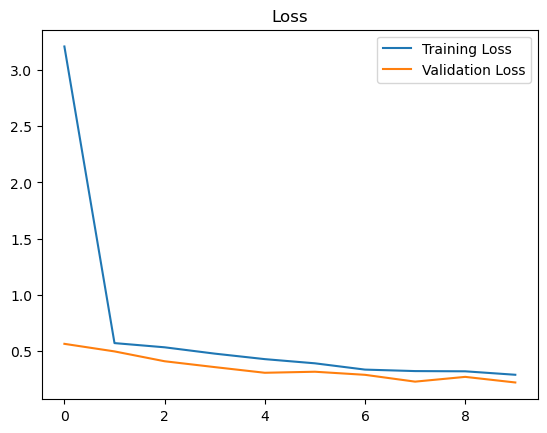

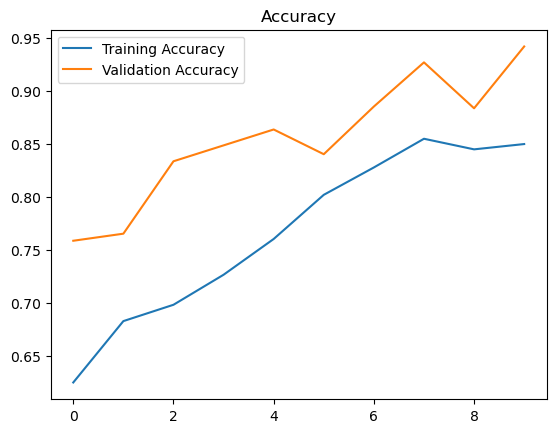

In [18]:
history_1 = model_1.history.history
plot_metrics(history_1)


## Model 2. Binary Cross Entropy

In [19]:
# Binary Cross Entropy with Sigmoid Function. 
dataset= np.array(dataset) 
label= np.array(label)

x_train, x_test, y_train, y_test = train_test_split(dataset, label, test_size=0.2, random_state=0)

x_train = normalize(x_train, axis=1)
x_test = normalize(x_test, axis=1)

In [22]:
# Model Building
model_2 = Sequential()

# first layer
model_2.add(Conv2D(filters= 32, kernel_size=(3,3), input_shape=(INPUT_SIZE, INPUT_SIZE, 3)))
model_2.add(Activation("relu"))
model_2.add(MaxPooling2D(pool_size=(2,2)))

# 1st hidden layer
model_2.add(Conv2D(filters= 32, kernel_size=(3,3), kernel_initializer="he_uniform"))
model_2.add(Activation("relu"))
model_2.add(MaxPooling2D(pool_size=(2,2)))

# 2nd hidden layer
model_2.add(Conv2D(filters= 64, kernel_size=(3,3), kernel_initializer="he_uniform"))
model_2.add(Activation("relu"))
model_2.add(MaxPooling2D(pool_size=(2,2)))

# Flatten Layer 
model_2.add(Flatten())
model_2.add(Dense(64))
model_2.add(Activation("relu"))
model_2.add(Dropout(0.5))

# Binary Cross Entropy = 1, sigmoid 
model_2.add(Dense(1))
model_2.add(Activation("sigmoid"))
model_2.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

### Model Architecture

In [23]:
model_2.summary() 

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 62, 62, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_10 (Activation)           │ (None, 62, 62, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 31, 31, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 29, 29, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_11 (Activation)           │ (None, 29, 29, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 12, 12, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_12 (Activation)           │ (None, 12, 12, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 2304)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │         147,520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_13 (Activation)           │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              65 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_14 (Activation)           │ (None, 1)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 176,225 (688.38 KB)

 Trainable params: 176,225 (688.38 KB)

 Non-trainable params: 0 (0.00 B)

In [24]:
model_2.fit(x_train, y_train, batch_size=32, verbose=True, epochs=10,
          validation_data=(x_test, y_test), shuffle=False)

model_2.save("BrainTumor10Epochs.h5")

Epoch 1/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 10s 80ms/step - accuracy: 0.6335 - loss: 0.6230 - val_accuracy: 0.7350 - val_loss: 0.5286
Epoch 2/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 74ms/step - accuracy: 0.7910 - loss: 0.4628 - val_accuracy: 0.7950 - val_loss: 0.4290
Epoch 3/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 74ms/step - accuracy: 0.8490 - loss: 0.3544 - val_accuracy: 0.7867 - val_loss: 0.4635
Epoch 4/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 75ms/step - accuracy: 0.8789 - loss: 0.2962 - val_accuracy: 0.8450 - val_loss: 0.3234
Epoch 5/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 75ms/step - accuracy: 0.9115 - loss: 0.2260 - val_accuracy: 0.9083 - val_loss: 0.2282
Epoch 6/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 75ms/step - accuracy: 0.9256 - loss: 0.1842 - val_accuracy: 0.9400 - val_loss: 0.1751
Epoch 7/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 75ms/step - accuracy: 0.9571 - loss: 0.1247 - val_accuracy: 0.9433 - val_loss: 0.1551
Epoch 8/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 77ms/step - accuracy: 0.9718 - loss: 0.0891 - val_accuracy: 0.9650 - 

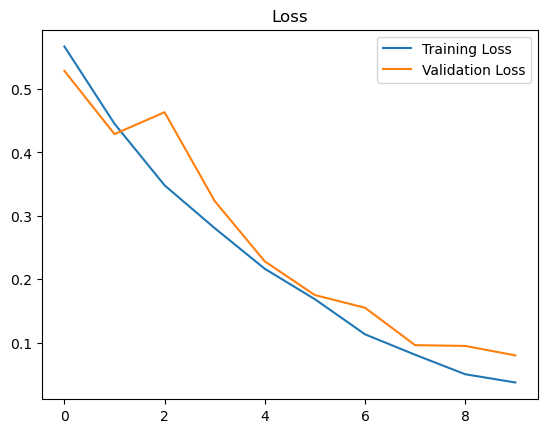

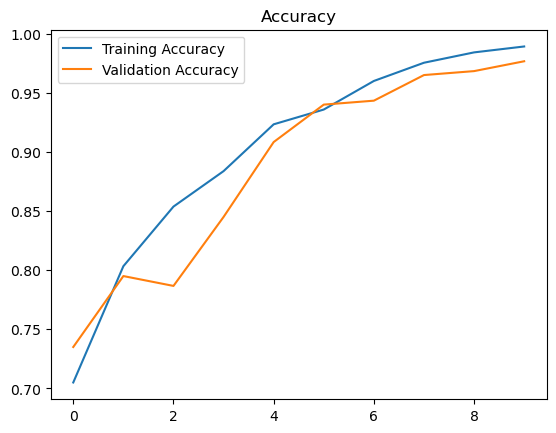

In [25]:
history_2 = model_2.history.history
plot_metrics(history_2)
